### IMPORTS & CONFIGURATION

In [1]:
# ================== IMPORTS & CONFIGURATION ==================
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, BatchNormalization, TimeDistributed, LayerNormalization
from tensorflow.keras.optimizers import Adam
import warnings
from statsmodels.tsa.arima.model import ARIMA
from dtaidistance import dtw
from scipy import signal
warnings.filterwarnings("ignore")

### DATA PREPROCESSING

In [2]:
# ================== DATA PREPROCESSING ==================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    if not np.issubdtype(df.iloc[:, 0].dtype, np.number):
        df_numeric = df.iloc[:, 1:]
    else:
        df_numeric = df.copy()
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_numeric)
    return data_scaled, df_numeric.columns.tolist(), scaler

### ARIMA MODELING

In [3]:
# ================== ARIMA MODELING FUNCTION ==================
# def make_stationary_and_fit_arima(data, columns):
#     arima_models = []
#     residuals = []
#     orders = []
    
#     for i in range(data.shape[1]):
#         series = pd.Series(data[:, i], name=columns[i])
        
#         # Handle NaN values - forward fill then drop any remaining
#         series = series.ffill().dropna()
        
#         if len(series) < 10:  # Skip if not enough data
#             print(f"Skipping {columns[i]} - insufficient data after cleaning")
#             arima_models.append(None)
#             residuals.append(np.zeros(data.shape[0]))  # Placeholder
#             orders.append((0, 0, 0))
#             continue
            
#         try:
#             # Stationarity check with error handling
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 result = adfuller(series)
#                 p_value = result[1]
                
#             if p_value > 0.05:
#                 stationary_series = series.diff().dropna()
#                 if len(stationary_series) < 5:  # Check if differencing left too few points
#                     stationary_series = series.copy()  # Fall back to original
#             else:
#                 stationary_series = series.copy()
                
#             # ARIMA fitting with more robust error handling
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 model = auto_arima(
#                     stationary_series,
#                     seasonal=False,
#                     suppress_warnings=True,
#                     error_action='ignore',
#                     maxiter=50,
#                     n_fits=10
#                 )
                
#             # Get residuals safely
#             try:
#                 pred = model.predict_in_sample()
#                 aligned_series = stationary_series[-len(pred):]
#                 res = aligned_series - pred
#             except:
#                 res = np.zeros(len(stationary_series))
                
#             # Pad residuals to match original length
#             padded_res = np.zeros(data.shape[0])
#             padded_res[-len(res):] = res
                
#             arima_models.append(model)
#             residuals.append(padded_res)
#             orders.append(model.order)
            
#         except Exception as e:
#             print(f"Failed on {columns[i]}: {str(e)}")
#             arima_models.append(None)
#             residuals.append(np.zeros(data.shape[0]))
#             orders.append((0, 0, 0))
    
#     # Convert to numpy array and trim
#     residuals = np.array(residuals).T
#     min_len = min(len(r[r != 0]) for r in residuals.T)  # Find first non-zero
#     residuals = np.array([r[-min_len:] for r in residuals.T]).T
    
#     return arima_models, residuals, orders

### TIME-GAN IMPLEMENTATION

In [4]:
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, TimeDistributed, LayerNormalization, Add, MultiHeadAttention, BatchNormalization

class TimeGAN:
    def __init__(self, seq_len, n_features, latent_dim=64):
        self.seq_len = seq_len
        self.n_features = n_features
        self.latent_dim = latent_dim
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.supervisor = self.build_supervisor()

        self.metrics = {
            'gen_loss': [],
            'disc_loss': [],
            'sup_loss': [],
            'disc_accuracy': []
        }

    def build_generator(self):
        inputs = Input(shape=(None, self.n_features))
        x1 = LSTM(128, return_sequences=True)(inputs)
        x1 = BatchNormalization()(x1)
        x1 = Dropout(0.2)(x1)

        x2 = LSTM(64, return_sequences=True)(x1)
        x2 = BatchNormalization()(x2)
        x2 = Dropout(0.2)(x2)

        x1_proj = TimeDistributed(Dense(64))(x1)
        x = Add()([x1_proj, x2])
        x = TimeDistributed(Dense(64, activation='tanh'))(x)
        outputs = TimeDistributed(Dense(self.n_features))(x)
        return Model(inputs, outputs)

    def build_discriminator(self):
        inputs = Input(shape=(None, self.n_features))
        x = GRU(32, return_sequences=True)(inputs)
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)
        attention = MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
        x = Add()([x, attention])
        x = GRU(32)(x)
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)
        x = Dense(32, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)
        return Model(inputs, outputs)

    def build_supervisor(self):
        inputs = Input(shape=(None, self.n_features))
        x = tf.keras.layers.Conv1D(256, kernel_size=5, padding="causal", activation='tanh')(inputs)
        x = LayerNormalization()(x)
        x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(x)
        attention = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = LayerNormalization()(x + attention)
        outputs = TimeDistributed(Dense(self.n_features))(x)
        return Model(inputs, outputs)

    def compile(self, lr=0.00068):
        self.generator_optimizer = Adam(lr)
        self.discriminator_optimizer = Adam(lr)
        self.supervisor_optimizer = Adam(lr)
        self.bce_loss = tf.keras.losses.BinaryCrossentropy()
        self.mse_loss = tf.keras.losses.MeanSquaredError()

    def _smooth_labels(self, y, flip_rate=0.05, smooth_real=0.9):
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        if tf.reduce_mean(y) > 0.5:
            y = tf.ones_like(y) * smooth_real
        else:
            y = tf.zeros_like(y)
        flip_mask = tf.random.uniform(shape=tf.shape(y)) < flip_rate
        y = tf.where(flip_mask, 1.0 - y, y)
        return y

    def train(self, data, epochs=1, batch_size=32):
        dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(1000).batch(batch_size)

        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            total_batches = tf.data.experimental.cardinality(dataset).numpy()
            curr_seq_len = min(self.seq_len, 10 + epoch * 2)
            teacher_forcing_ratio = max(0.3, 0.9 - (epoch * 0.05))

            for batch in tqdm(dataset, total=total_batches, desc="Training"):
                batch = batch[:, :curr_seq_len, :]

                with tf.GradientTape(persistent=True) as tape:
                    synthetic_batch = self.generator(batch, training=True)

                    if tf.random.uniform(()) < teacher_forcing_ratio:
                        pred = self.supervisor(batch[:, :-1], training=True)
                        sup_loss = self.mse_loss(batch[:, 1:], pred)
                    else:
                        pred = self.supervisor(synthetic_batch[:, :-1], training=True)
                        sup_loss = self.mse_loss(synthetic_batch[:, 1:], pred)

                    real_output = self.discriminator(batch, training=True)
                    fake_output = self.discriminator(synthetic_batch, training=True)

                    real_y = self._smooth_labels(tf.ones_like(real_output))
                    fake_y = self._smooth_labels(tf.zeros_like(fake_output))

                    disc_loss = 0.5 * (
                        self.bce_loss(real_y, real_output) +
                        self.bce_loss(fake_y, fake_output)
                    )

                    gen_loss = self.bce_loss(tf.ones_like(fake_output), fake_output)
                    fm_loss = tf.reduce_mean(tf.abs(tf.reduce_mean(real_output, axis=0) - tf.reduce_mean(fake_output, axis=0)))
                    total_loss = gen_loss + 0.5 * sup_loss + 0.1 * fm_loss

                # Generator + Supervisor update
                gen_vars = self.generator.trainable_variables + self.supervisor.trainable_variables
                gen_grads = tape.gradient(total_loss, gen_vars)
                gen_grads, _ = tf.clip_by_global_norm(gen_grads, 5.0)
                self.generator_optimizer.apply_gradients(zip(gen_grads, gen_vars))

                # Discriminator update (with freeze if too accurate)
                disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
                disc_grads, _ = tf.clip_by_global_norm(disc_grads, 5.0)

                avg_acc = tf.reduce_mean(tf.cast(
                    tf.concat([
                        tf.round(real_output),
                        tf.round(1 - fake_output)
                    ], axis=0), tf.float32))

                if avg_acc < 0.95:
                    self.discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

                # Record metrics
                self.metrics['gen_loss'].append(gen_loss.numpy())
                self.metrics['disc_loss'].append(disc_loss.numpy())
                self.metrics['sup_loss'].append(sup_loss.numpy())
                self.metrics['disc_accuracy'].append(avg_acc.numpy())

            print(f"Seq Length: {curr_seq_len}/{self.seq_len}")
            print(f"Generator Loss: {np.mean(self.metrics['gen_loss'][-total_batches:]):.4f}")
            print(f"Discriminator Loss: {np.mean(self.metrics['disc_loss'][-total_batches:]):.4f}")
            print(f"Supervisor Loss: {np.mean(self.metrics['sup_loss'][-total_batches:]):.4f}")
            print(f"Discriminator Accuracy: {np.mean(self.metrics['disc_accuracy'][-total_batches:]):.4f}")

    def plot_training_history(self):
        epochs = range(1, len(self.metrics['gen_loss']) + 1)
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.metrics['gen_loss'], label='Generator Loss')
        plt.plot(epochs, self.metrics['sup_loss'], label='Supervisor Loss')
        plt.plot(epochs, self.metrics['disc_loss'], label='Discriminator Loss')
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.metrics['disc_accuracy'], label='Discriminator Accuracy')
        plt.title("Discriminator Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


### EVALUATION METRICS

In [5]:
# ================== EVALUATION METRICS ==================
class HybridModelEvaluator:
    def __init__(self, real_data, synthetic_data, arima_models):
        self.real_data = real_data
        self.synthetic_data = synthetic_data
        self.arima_models = arima_models
        self.scaler = MinMaxScaler()
        
    def calculate_metrics(self):
        metrics = {}
        
        # 1. Discriminative Score
        metrics.update(self._calculate_discriminative_score())
        
        # 2. Distribution Similarity
        metrics.update(self._calculate_distribution_similarity())
        
        # 3. Temporal Dynamics Metrics
        metrics.update(self._calculate_temporal_metrics())
        
        # 4. Reconstruction Error
        metrics.update(self._calculate_reconstruction_error())
        
        # 5. Anomaly Detection Performance
        metrics.update(self._calculate_anomaly_detection_metrics())
        
        return metrics
    
    def _calculate_discriminative_score(self):
        # Flatten the time dimension
        real_flat = self.real_data.reshape(-1, self.real_data.shape[-1])
        synth_flat = self.synthetic_data.reshape(-1, self.synthetic_data.shape[-1])
        
        # Create labels
        X = np.vstack([real_flat, synth_flat])
        y = np.hstack([np.zeros(len(real_flat)), np.ones(len(synth_flat))])
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        # Train classifier
        clf = IsolationForest(random_state=42).fit(X_train)
        
        # Calculate score
        score = clf.score_samples(X_test)
        real_score = score[y_test == 0]
        synth_score = score[y_test == 1]
        
        t_stat, p_value = stats.ttest_ind(real_score, synth_score)
        
        return {
            'discriminative_score': np.mean(synth_score) - np.mean(real_score),
            'discriminative_p_value': p_value
        }
    
    def _calculate_distribution_similarity(self):
        real_flat = self.real_data.reshape(-1, self.real_data.shape[-1])
        synth_flat = self.synthetic_data.reshape(-1, self.synthetic_data.shape[-1])
        
        ks_stats = []
        for i in range(real_flat.shape[1]):
            ks_stat = stats.ks_2samp(real_flat[:, i], synth_flat[:, i])
            ks_stats.append(ks_stat.statistic)
        
        return {
            'avg_ks_statistic': np.mean(ks_stats),
            'feature_ks_statistics': ks_stats
        }
    
    def _calculate_temporal_metrics(self):
        # Calculate autocorrelation similarity
        def autocorr(x, lag=1):
            return np.corrcoef(x[lag:], x[:-lag])[0, 1]
        
        real_ac = []
        synth_ac = []
        for i in range(self.real_data.shape[-1]):
            real_ac.append(autocorr(self.real_data[:, 0, i]))
            synth_ac.append(autocorr(self.synthetic_data[:, 0, i]))
        
        ac_diff = np.mean(np.abs(np.array(real_ac) - np.array(synth_ac)))
        
        return {
            'autocorrelation_difference': ac_diff,
            'real_autocorrelations': real_ac,
            'synth_autocorrelations': synth_ac
        }

    def _calculate_reconstruction_error(self):
        # Reconstruct synthetic data using ARIMA models
        reconstructed = []
        for seq in self.synthetic_data:
            seq_reconstructed = []
            for i, model in enumerate(self.arima_models):
                if model is None:  # Handle cases where model wasn't created
                    seq_reconstructed.append(seq[:, i])
                    continue
                    
                # Forecast only seq_len steps ahead
                forecast = model.forecast(steps=len(seq))
                forecast = np.asarray(forecast)  # Convert to numpy array
                
                # Ensure shapes match
                if len(forecast) != len(seq):
                    forecast = forecast[:len(seq)]  # Truncate if needed
                    
                seq_reconstructed.append(forecast + seq[:, i])
                
            reconstructed.append(np.stack(seq_reconstructed, axis=1))
        
        reconstructed = np.array(reconstructed)
        
        # Calculate errors
        mse = mean_squared_error(
            self.synthetic_data.flatten(),
            reconstructed.flatten())
        
        mae = mean_absolute_error(
            self.synthetic_data.flatten(),
            reconstructed.flatten())
        
        return {
            'reconstruction_mse': mse,
            'reconstruction_mae': mae
        }
    
    # def _calculate_anomaly_detection_metrics(self):
    #     # Inject anomalies into synthetic data
    #     def inject_anomalies(data, ratio=0.1):
    #         anomalies = data.copy()
    #         n_anomalies = int(len(data) * ratio)
    #         idx = np.random.choice(len(data), n_anomalies, replace=False)
    #         anomalies[idx] *= 5  # Spike anomalies
    #         return anomalies, idx
        
    #     # Create dataset with labeled anomalies
    #     synth_normal = self.synthetic_data
    #     synth_anomalous, anomaly_idx = inject_anomalies(synth_normal)
        
    #     # Train detector on real data
    #     detector = IsolationForest(random_state=42)
    #     detector.fit(self.real_data.reshape(len(self.real_data), -1))
        
    #     # Evaluate detection
    #     scores = detector.score_samples(synth_anomalous.reshape(len(synth_anomalous), -1))
        
    #     # Calculate precision at k
    #     k = len(anomaly_idx)
    #     top_k = np.argsort(scores)[:k]
    #     true_positives = len(set(top_k) & set(anomaly_idx))
    #     precision = true_positives / k
        
    #     return {
    #         'anomaly_detection_precision': precision,
    #         'anomaly_scores': scores
    #     }
    
    def _calculate_anomaly_detection_metrics(self):
        def inject_anomalies(batch, anomaly_rate=0.1):
            """Inject realistic anomalies into synthetic batch (numpy array)"""
            anomalies = batch.copy()
            anomaly_idx = set()

            # 1. Point anomalies (spikes)
            spike_count = int(anomaly_rate * len(anomalies))
            spike_idx = np.random.choice(len(anomalies), spike_count, replace=False)
            anomalies[spike_idx] *= 3.0  # Magnitude spike
            anomaly_idx.update(spike_idx.tolist())

            # 2. Contextual anomalies (sequence breaks)
            for i in range(0, len(anomalies), self.real_data.shape[1] // 4):
                if i + 2 < len(anomalies):
                    anomalies[i:i+2] = np.flip(anomalies[i:i+2], axis=0)
                    anomaly_idx.update(range(i, i+2))

            return anomalies, list(anomaly_idx)

        # Step 1: Anomaly Injection
        synth_normal = self.synthetic_data  # already numpy
        synth_anomalous, anomaly_idx = inject_anomalies(synth_normal)

        # Step 2: Train detector on real data
        X_train = self.real_data.reshape(len(self.real_data), -1)
        X_test = synth_anomalous.reshape(len(synth_anomalous), -1)

        detector = IsolationForest(random_state=42).fit(X_train)

        # Step 3: Score
        scores = detector.score_samples(X_test)

        # Step 4: Precision at K
        k = len(anomaly_idx)
        top_k = np.argsort(scores)[:k]  # Smaller = more anomalous
        true_positives = len(set(top_k) & set(anomaly_idx))
        precision = true_positives / k if k > 0 else 0

        return {
            'anomaly_detection_precision': precision,
            'anomaly_scores': scores,
            'true_anomalies': anomaly_idx
        }

## Load Arima Metadata

In [6]:
import json
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

def load_arima_from_full_metadata(metadata_path, data_scaled):
    with open(metadata_path, "r") as f:
        metadata = json.load(f)

    arima_models = []
    residuals = []
    columns = []
    
    for i, sensor_info in enumerate(metadata):
        sensor_name = sensor_info["sensor"]
        order = tuple(sensor_info["order"])
        columns.append(sensor_name)

        print(f"Restoring ARIMA for {sensor_name} with order {order}")
        series = pd.Series(data_scaled[:, i], name=sensor_name).ffill().dropna()

        if len(series) < 10:
            print(f"  WARNING: Not enough data for {sensor_name}")
            arima_models.append(None)
            residuals.append(np.zeros(data_scaled.shape[0]))
            continue

        try:
            model = ARIMA(series, order=order).fit()
            pred = model.predict()
            aligned = series[-len(pred):]
            res = aligned - pred

            padded_res = np.zeros(data_scaled.shape[0])
            padded_res[-len(res):] = res

            arima_models.append(model)
            residuals.append(padded_res)
            print(f"  Residuals range: [{res.min():.4f}, {res.max():.4f}]")
        except Exception as e:
            print(f"  ERROR for {sensor_name}: {e}")
            arima_models.append(None)
            residuals.append(np.zeros(data_scaled.shape[0]))

    residuals = np.array(residuals).T
    min_len = min(len(r[r != 0]) for r in residuals.T)
    residuals = np.array([r[-min_len:] for r in residuals.T]).T
    print(f"Residuals matrix shape: {residuals.shape}")

    return arima_models, residuals, columns


def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

## Load Main Pipeline with pre-trained ARIMA metadata

In [7]:
# Step 1: Load data and restore ARIMA models
print("Loading data and restoring ARIMA metadata...")
data_scaled, _, _ = load_and_preprocess_data("../databases/processed_data/TimeGAN_data.csv")
arima_models, residuals, columns = load_arima_from_full_metadata("arima_metadata.json", data_scaled)

Loading data and restoring ARIMA metadata...
Restoring ARIMA for cooling_channel0 with order (2, 1, 2)
  Residuals range: [-0.0563, 0.0494]
Restoring ARIMA for cooling_channel1 with order (1, 1, 4)
  Residuals range: [-0.0464, 0.0397]
Restoring ARIMA for cooling_channel10 with order (5, 1, 5)
  Residuals range: [-0.0540, 0.0490]
Restoring ARIMA for cooling_channel11 with order (1, 1, 4)
  Residuals range: [-0.0419, 0.0396]
Restoring ARIMA for maxigauge_channel1 with order (3, 1, 3)
  Residuals range: [-0.0664, 0.1304]
Restoring ARIMA for maxigauge_channel2 with order (4, 1, 5)
  Residuals range: [-0.3471, 0.2746]
Restoring ARIMA for maxigauge_channel3 with order (2, 1, 5)
  Residuals range: [-0.0890, 0.0751]
Restoring ARIMA for maxigauge_channel4 with order (2, 1, 3)
  Residuals range: [-0.1059, 0.1247]
Restoring ARIMA for maxigauge_channel5 with order (1, 1, 2)
  Residuals range: [-0.1588, 0.9618]
Restoring ARIMA for maxigauge_channel6 with order (1, 1, 3)
  Residuals range: [-0.3244,

In [8]:
def main():
    # Step 2: Prepare TimeGAN training data
    print("\nPreparing TimeGAN training data...")
    seq_len = 60
    n_features = residuals.shape[1]
    residual_sequences = create_sequences(residuals, seq_len)
    print(f"Created {len(residual_sequences)} training sequences")

    # Step 3: Train TimeGAN
    print("\nTraining TimeGAN...")
    timegan = TimeGAN(seq_len=seq_len, n_features=n_features)
    timegan.compile(lr=0.0001)
    timegan.train(residual_sequences, epochs=1, batch_size=32)
    timegan.plot_training_history()

    # 4. Generate synthetic residuals
    print("\nGenerating synthetic data...")
    noise = np.random.normal(size=(100, seq_len, n_features))
    synthetic_residuals = timegan.generator.predict(noise)
    
    # 5. Reconstruct full synthetic time series
    print("\nReconstructing synthetic time series...")
    synthetic_data = []

    for seq in synthetic_residuals:
        reconstructed_seq = []
        for i, model in enumerate(arima_models):
            if model is None:
                reconstructed_seq.append(seq[:, i])
                continue
            forecast = model.forecast(steps=seq_len)
            forecast = np.asarray(forecast)
            reconstructed_seq.append(forecast + seq[:, i])
        synthetic_data.append(np.stack(reconstructed_seq, axis=1))

    synthetic_data = np.array(synthetic_data)


    # Step 6: Evaluate the hybrid model
    print("\nEvaluating model performance...")
    evaluator = HybridModelEvaluator(
        real_data=residual_sequences,
        synthetic_data=synthetic_data,
        arima_models=arima_models
    )
    metrics = evaluator.calculate_metrics()
    
    print("\n=== Evaluation Results ===")
    for k, v in metrics.items():
        if isinstance(v, (list, np.ndarray)):
            print(f"{k}: {np.mean(v):.4f} (avg)")
        else:
            print(f"{k}: {v:.4f}")

    # Step 7: Visualize comparison for all channels
    print("\nVisualizing real vs synthetic residuals for all channels...")
    plt.figure(figsize=(14, 4 * n_features))  # 动态设置图像高度以避免拥挤

    for i in range(n_features):
        plt.subplot(n_features, 1, i + 1)
        plt.plot(residual_sequences[0, :, i], label='Real')
        plt.plot(synthetic_data[0, :, i], label='Synthetic', alpha=0.7)
        plt.title(f"Channel {i+1}: {columns[i]}")
        plt.ylabel("Residual")
        plt.legend()  # 每个 subplot 都有图例
        if i == n_features - 1:
            plt.xlabel("Time Step")

    plt.tight_layout()
    plt.show()


Preparing TimeGAN training data...
Created 45352 training sequences

Training TimeGAN...

Epoch 1/1


Training: 100%|██████████| 1418/1418 [05:54<00:00,  4.00it/s]

Seq Length: 10/60
Generator Loss: 0.9647
Discriminator Loss: 0.5037
Supervisor Loss: 0.0618
Discriminator Accuracy: 0.8922


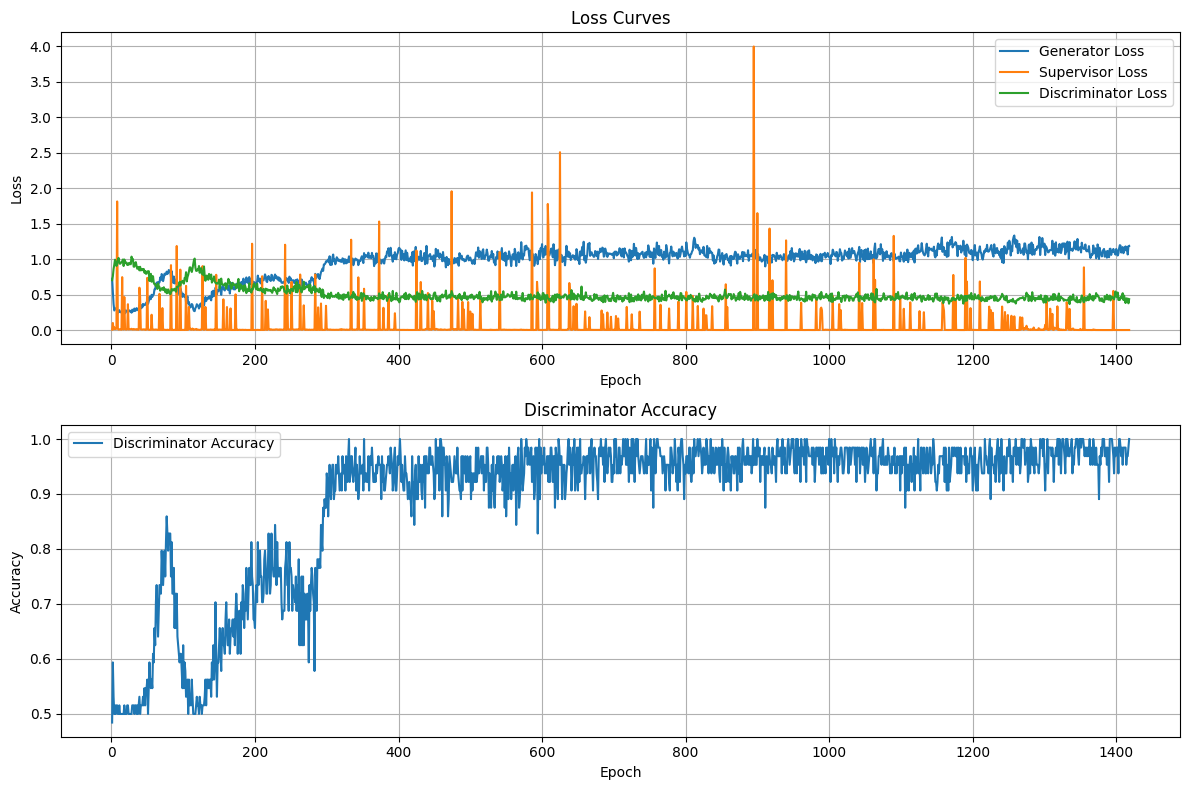


Generating synthetic data...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step

Reconstructing synthetic time series...

Evaluating model performance...

=== Evaluation Results ===
discriminative_score: -0.4743
discriminative_p_value: 0.0000
avg_ks_statistic: 0.8568
feature_ks_statistics: 0.8568 (avg)
autocorrelation_difference: 0.3037
real_autocorrelations: 0.2164 (avg)
synth_autocorrelations: -0.0547 (avg)
reconstruction_mse: 0.2657
reconstruction_mae: 0.3020
anomaly_detection_precision: 0.2174
anomaly_scores: -0.8004 (avg)
true_anomalies: 48.1739 (avg)

Visualizing real vs synthetic residuals for all channels...


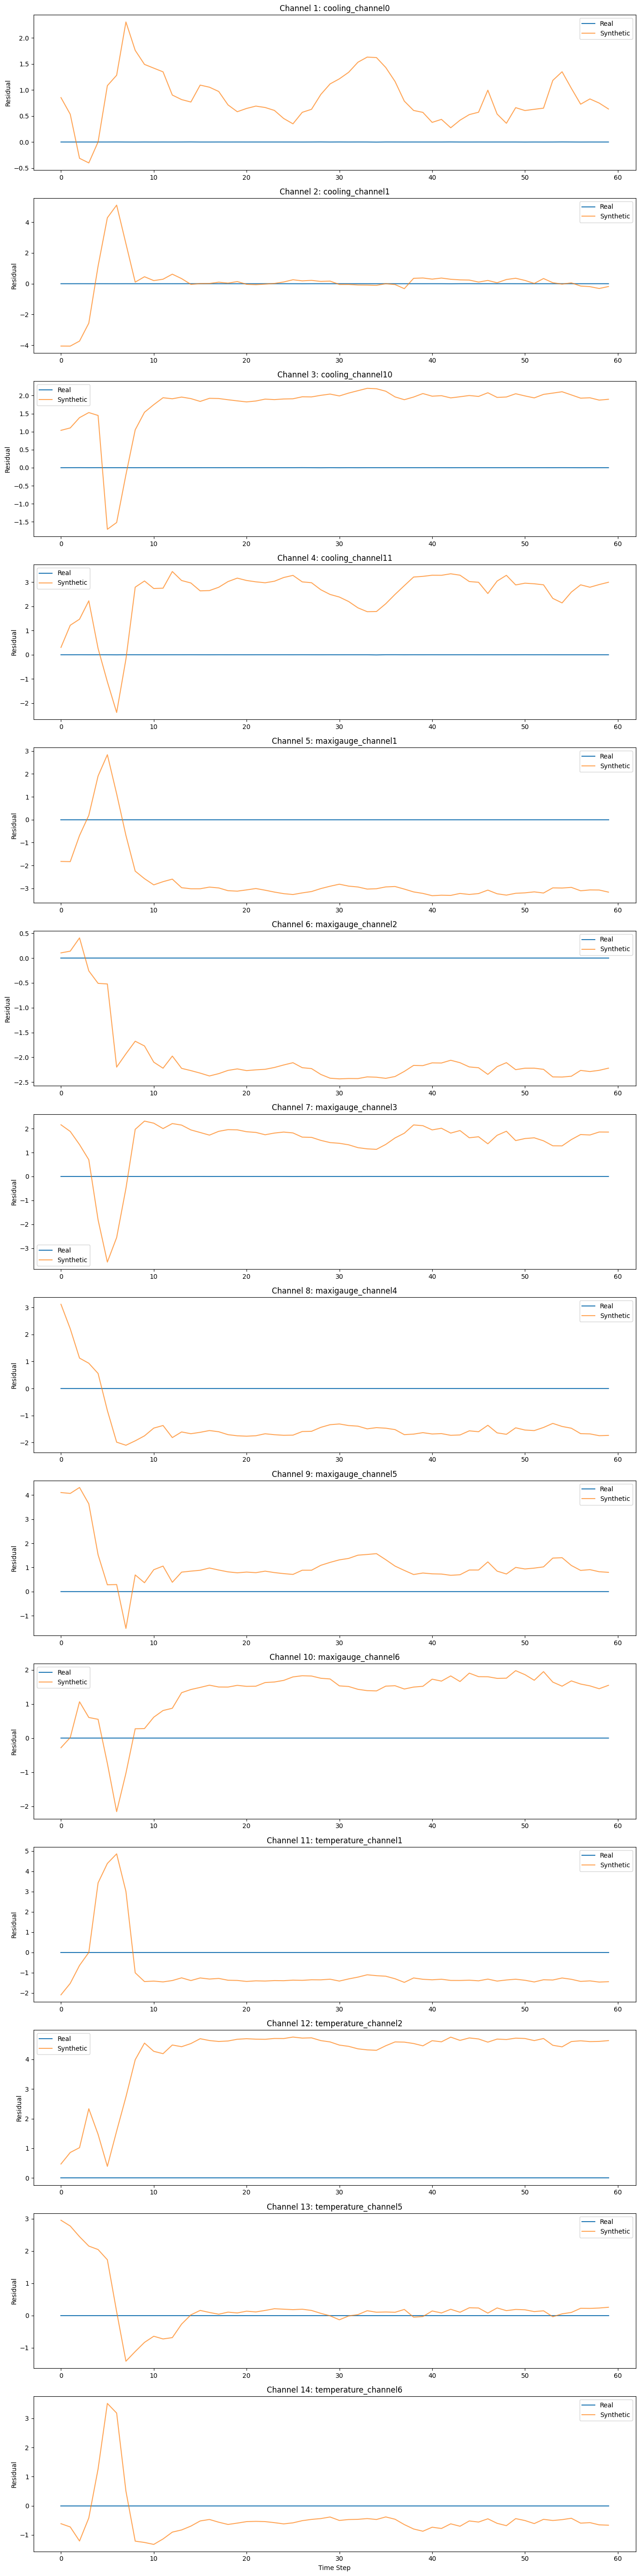

In [9]:
if __name__ == "__main__":
    main()

## With Embedder and recovery

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, TimeDistributed, LayerNormalization, Add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
class ImprovedTimeGAN:
    def __init__(self, seq_len, n_features, latent_dim=32):
        self.seq_len = seq_len
        self.n_features = n_features
        self.latent_dim = latent_dim

        # Build all components (with dynamic time input)
        self.embedder = self._build_embedder()
        self.recovery = self._build_recovery()
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        self.supervisor = self._build_supervisor()

        self.metrics = {
            'gen_loss': [], 'disc_loss': [], 'sup_loss': [],
            'embed_loss': [], 'dtw_score': [], 'psd_diff': []
        }

    def _build_embedder(self):
        inputs = Input(shape=(None, self.n_features))
        x = LSTM(128, return_sequences=True)(inputs)
        x = BatchNormalization()(x)
        x = LSTM(64, return_sequences=True)(x)
        outputs = TimeDistributed(Dense(self.latent_dim))(x)
        return Model(inputs, outputs, name="Embedder")

    def _build_recovery(self):
        inputs = Input(shape=(None, self.latent_dim))
        x = LSTM(64, return_sequences=True)(inputs)
        x = TimeDistributed(Dense(self.n_features))(x)
        return Model(inputs, x, name="Recovery")

    def _build_generator(self):
        inputs = Input(shape=(None, self.latent_dim))
        x = LSTM(256, return_sequences=True)(inputs)
        x = LayerNormalization()(x)
        x = Dropout(0.1246)(x)
        x_skip = x

        x = LSTM(96, return_sequences=True)(x)
        x = LayerNormalization()(x)
        x = Dropout(0.1246)(x)

        x_skip_proj = TimeDistributed(Dense(96))(x_skip)
        x = Add()([x, x_skip_proj])
        x = TimeDistributed(Dense(64, activation='tanh'))(x)
        outputs = TimeDistributed(Dense(self.latent_dim, activation='tanh'))(x)
        return Model(inputs, outputs, name="Generator")

    def _build_discriminator(self):
        inputs = Input(shape=(None, self.latent_dim))
        x = GRU(32, return_sequences=True)(inputs)
        x = LayerNormalization()(x)
        x = Dropout(0.1767)(x)
        x = GRU(32)(x)
        x = LayerNormalization()(x)
        x = Dropout(0.1767)(x)
        x = Dense(32, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)
        return Model(inputs, outputs, name="Discriminator")

    def _build_supervisor(self):
        inputs = Input(shape=(None, self.latent_dim))
        x = LSTM(256, return_sequences=True)(inputs)
        x = LayerNormalization()(x)
        x = LSTM(96, return_sequences=True)(x)
        x = LayerNormalization()(x)
        outputs = TimeDistributed(Dense(self.latent_dim))(x)
        return Model(inputs, outputs, name="Supervisor")

    def compile(self, lr=0.0001):
        self.gen_optimizer = Adam(lr)
        self.disc_optimizer = Adam(lr)
        self.sup_optimizer = Adam(lr)
        self.embed_optimizer = Adam(lr)
        self.bce_loss = tf.keras.losses.BinaryCrossentropy()
        self.mse_loss = tf.keras.losses.MeanSquaredError()

    def train(self, real_data, epochs=100, batch_size=64):
        dataset = tf.data.Dataset.from_tensor_slices(real_data).shuffle(1000).batch(batch_size)
        for epoch in range(epochs):
            curr_seq_len = min(self.seq_len, 10 + epoch // 5)
            print(f"\nEpoch {epoch+1}/{epochs} - Training on {curr_seq_len} steps")
            for batch in tqdm(dataset, desc="Training"):
                batch = batch[:, :curr_seq_len, :]
                self._train_step(batch)
            self._evaluate_metrics(real_data[:100])
            self._print_metrics(epoch)

    def _train_step(self, real_sequences):
        with tf.GradientTape() as embed_tape:
            H = self.embedder(real_sequences, training=True)
            X_tilde = self.recovery(H, training=True)
            embed_loss = self.mse_loss(real_sequences, X_tilde)

        with tf.GradientTape(persistent=True) as gen_tape:
            E_hat = self.generator(H, training=True)
            H_hat = self.supervisor(E_hat, training=True)

            Y_real = self.discriminator(H, training=True)
            Y_fake = self.discriminator(H_hat, training=True)

            gen_loss = self.bce_loss(tf.ones_like(Y_fake), Y_fake)
            sup_loss = self.mse_loss(H[:, 1:], H_hat[:, :-1])
            fm_loss = tf.reduce_mean(tf.abs(tf.reduce_mean(Y_real, axis=0) - tf.reduce_mean(Y_fake, axis=0)))
            total_loss = gen_loss + 0.5 * sup_loss + 0.1 * fm_loss

        embed_grads = embed_tape.gradient(embed_loss, self.embedder.trainable_variables)
        self.embed_optimizer.apply_gradients(zip(embed_grads, self.embedder.trainable_variables))

        gen_grads = gen_tape.gradient(total_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

        sup_grads = gen_tape.gradient(sup_loss, self.supervisor.trainable_variables)
        self.sup_optimizer.apply_gradients(zip(sup_grads, self.supervisor.trainable_variables))

        with tf.GradientTape() as disc_tape:
            Y_real_d = self.discriminator(H, training=True)
            Y_fake_d = self.discriminator(H_hat, training=True)
            disc_loss = 0.5 * (self.bce_loss(tf.ones_like(Y_real_d), Y_real_d) + self.bce_loss(tf.zeros_like(Y_fake_d), Y_fake_d))

        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        self.metrics['gen_loss'].append(gen_loss.numpy())
        self.metrics['disc_loss'].append(disc_loss.numpy())
        self.metrics['sup_loss'].append(sup_loss.numpy())
        self.metrics['embed_loss'].append(embed_loss.numpy())

    def _evaluate_metrics(self, real_data):
        # Embed → Generate → Recover
        H = self.embedder(real_data)
        synthetic_data = self.recovery(self.generator(H))

        try:
            from dtaidistance import dtw
            dtw_scores = [
                dtw.distance(
                    real_data[i].flatten() if isinstance(real_data, np.ndarray) else real_data[i].numpy().flatten(),
                    synthetic_data[i].flatten() if isinstance(synthetic_data, np.ndarray) else synthetic_data[i].numpy().flatten()
                )
                for i in range(min(10, len(real_data)))
            ]
            self.metrics['dtw_score'].append(np.mean(dtw_scores))
        except Exception as e:
            print("⚠️ DTW failed:", e)
            self.metrics['dtw_score'].append(0.0)

        real_flat = real_data[:10].flatten() if isinstance(real_data, np.ndarray) else real_data[:10].numpy().flatten()
        synth_flat = synthetic_data[:10].flatten() if isinstance(synthetic_data, np.ndarray) else synthetic_data[:10].numpy().flatten()

        f_real, Pxx_real = signal.welch(real_flat)
        f_synth, Pxx_synth = signal.welch(synth_flat)

        self.metrics['psd_diff'].append(np.mean(np.abs(Pxx_real - Pxx_synth)))

    def _print_metrics(self, epoch):
        print(f"\nMetrics after epoch {epoch+1}:")
        print(f"Generator Loss: {self.metrics['gen_loss'][-1]:.4f}")
        print(f"Discriminator Loss: {self.metrics['disc_loss'][-1]:.4f}")
        print(f"Supervisor Loss: {self.metrics['sup_loss'][-1]:.4f}")
        print(f"Embedding Loss: {self.metrics['embed_loss'][-1]:.4f}")
        print(f"DTW Score: {self.metrics['dtw_score'][-1]:.4f}")
        print(f"PSD Difference: {self.metrics['psd_diff'][-1]:.4f}")

    def plot_training_history(self):
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        plt.plot(self.metrics['gen_loss'], label='Generator')
        plt.plot(self.metrics['disc_loss'], label='Discriminator')
        plt.title('Adversarial Training Loss')
        plt.legend()
        plt.subplot(2, 2, 2)
        plt.plot(self.metrics['sup_loss'], label='Supervisor')
        plt.plot(self.metrics['embed_loss'], label='Embedder')
        plt.title('Auxiliary Losses')
        plt.legend()
        plt.subplot(2, 2, 3)
        plt.plot(self.metrics['dtw_score'])
        plt.title('DTW Score (Lower is Better)')
        plt.subplot(2, 2, 4)
        plt.plot(self.metrics['psd_diff'])
        plt.title('PSD Difference (Lower is Better)')
        plt.tight_layout()
        plt.show()

In [12]:
class HybridARIMAGenerator:
    def __init__(self, timegan_model):
        self.timegan = timegan_model
        self.arima_models = []

    def fit_arima(self, real_data, order=(1,0,1)):
        print("Training ARIMA models with rolling windows...")
        window_size = self.timegan.seq_len
        for i in range(real_data.shape[-1]):
            feature_series = pd.Series(real_data[:, i])
            models = []
            for j in tqdm(range(len(feature_series) - window_size), desc=f"Feature {i+1}"):
                window = feature_series.iloc[j:j+window_size]
                try:
                    model = ARIMA(window, order=order).fit()
                    models.append(model)
                except:
                    models.append(None)
            self.arima_models.append(models)

    def generate_hybrid_samples(self, n_samples=100):
        print("\nGenerating hybrid samples...")
        synthetic_samples = []
        for _ in tqdm(range(n_samples)):
            arima_series = []
            for models in self.arima_models:
                valid_models = [m for m in models if m is not None]
                if not valid_models:
                    arima_series.append(np.zeros((self.timegan.seq_len,)))
                    continue
                model = np.random.choice(valid_models)
                forecast = model.forecast(steps=self.timegan.seq_len)
                arima_series.append(forecast.values)
            arima_series = np.stack(arima_series, axis=1)
            noise = np.random.normal(size=(1, self.timegan.seq_len, self.timegan.latent_dim))
            gan_residuals = self.timegan.recovery(self.timegan.generator(noise)).numpy()[0]
            synthetic = arima_series * 0.7 + gan_residuals * 0.3
            synthetic_samples.append(synthetic)
        return np.array(synthetic_samples)


Epoch 1/1 - Training on 10 steps


Training: 100%|██████████| 2158/2158 [12:08<00:00,  2.96it/s]



Metrics after epoch 1:
Generator Loss: nan
Discriminator Loss: nan
Supervisor Loss: nan
Embedding Loss: nan
DTW Score: nan
PSD Difference: nan


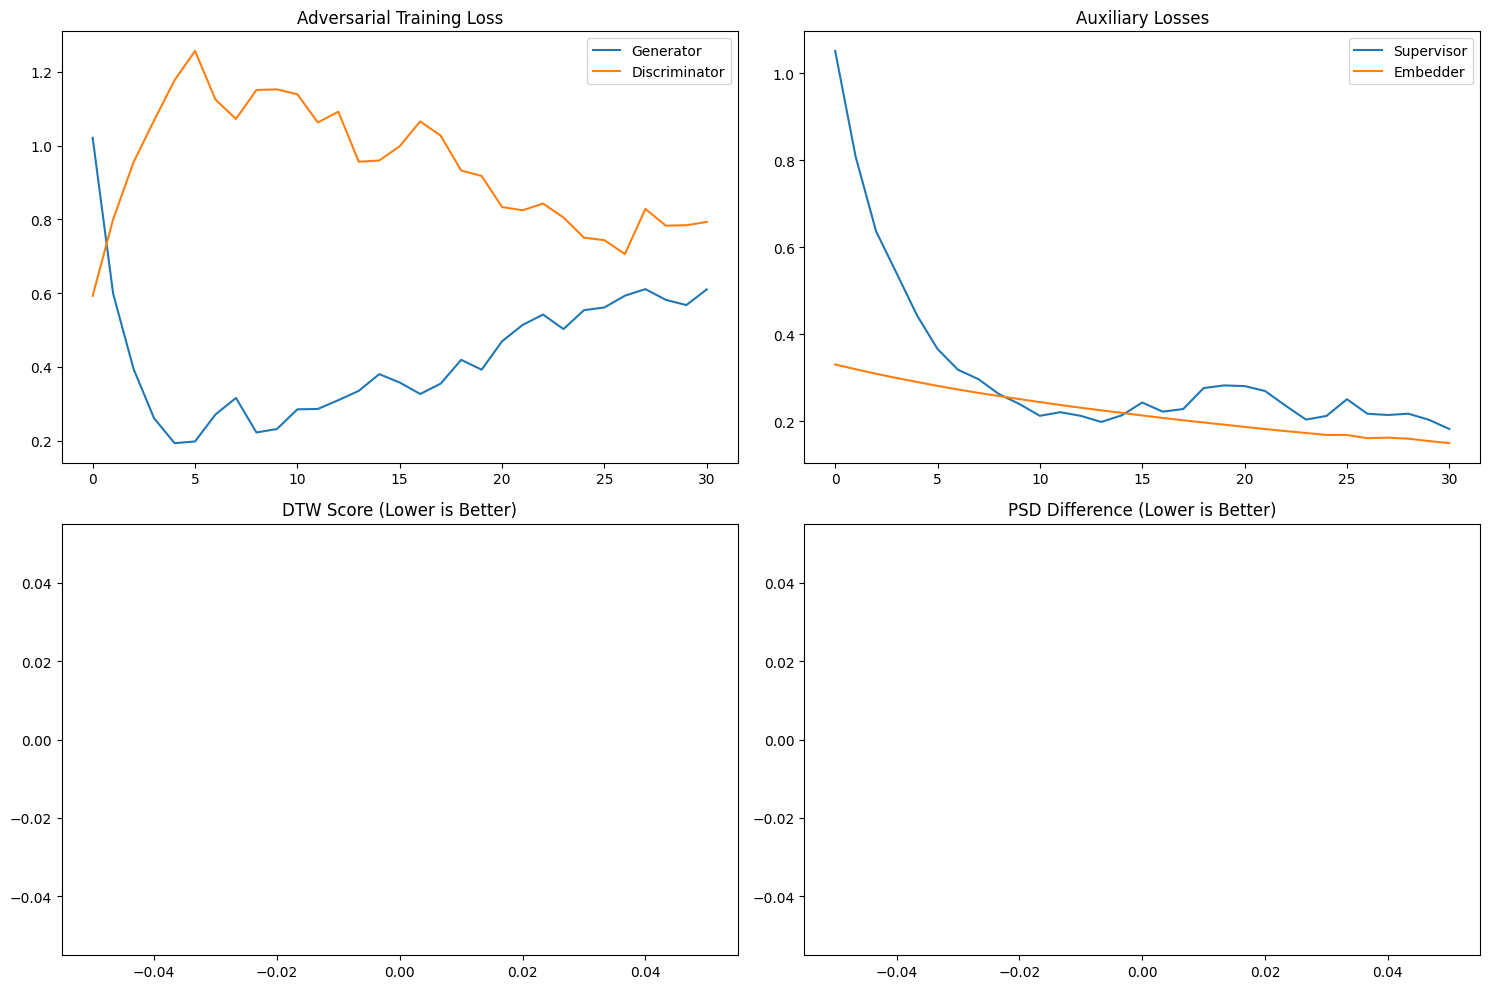

Training ARIMA models with rolling windows...


Feature 4:  55%|█████▌    | 38174/69052 [13:41<10:12, 50.39it/s]

In [ ]:
if __name__ == "__main__":
    df = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")
    time_col = df.columns[0] if not np.issubdtype(df.iloc[:, 0].dtype, np.number) else None
    df_numeric = df.select_dtypes(include=[np.number])

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_numeric)

    seq_len = 60
    sequences = np.array([
        data_scaled[i:i+seq_len] 
        for i in range(len(data_scaled)-seq_len+1)
    ])

    timegan = ImprovedTimeGAN(seq_len=seq_len, n_features=df_numeric.shape[1])
    timegan.compile(lr=0.0002)
    timegan.train(sequences, epochs=1, batch_size=32)
    timegan.plot_training_history()

    hybrid_gen = HybridARIMAGenerator(timegan)
    hybrid_gen.fit_arima(data_scaled)

    synthetic_data = hybrid_gen.generate_hybrid_samples(1000)
    synthetic_original_scale = scaler.inverse_transform(
        synthetic_data.reshape(-1, df_numeric.shape[1]))
